# Assignment 1 Part 1: Ray Triangle Intersection

In this assignment, you will implement a simple ray tracer that can render triangle meshes using ray casting. You will complete the following tasks:

- Learn about basics for Slang
- Implement ray-triangle intersection test
- Generate camera rays for each pixel
- Render a triangle mesh using ray casting
- Use supersampling to reduce aliasing artifacts
- Implement transformations for rays and cameras

Please run the following cell to set up the environment for this assignment.

In [1]:
import pathlib
from pyglm import glm
import numpy as np
from matplotlib import pyplot as plt
import slangpy as spy

from cs248a_renderer import setup_device, RendererModules
from cs248a_renderer.model.mesh import Mesh, create_triangle_buf
from cs248a_renderer.model.scene import Scene

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Slang: A Modern Shading Language

This quarter, a major change we are making to the assignments is to use the [Slang](https://shader-slang.org) shading language for all the assigments.

If you've exposed to graphics programming before, you may have heard of GLSL or HLSL. Compared to these traditional shading languages, Slang introduces several modern programming language features, such as generics, interfaces, and modules. These features make it easier to write reusable and maintainable code for graphics applications. Most importantly, Slang comes with the automatic differentiation feature, which we will leverage in reconstruction assignments later in the course.

It's OK if you are not familiar with any shading languages or GPU programming. We will try to walk you through some of the basics in this notebook. If you want to learn more about Slang and SlangPy binding, please read the [SlangPy Tutorial](https://slangpy.shader-slang.org/en/latest/src/basics/firstfunctions.html).

### Device and Module Setup

The first step to using Slang is to set up a Slang device. The device is an abstraction that represents the GPU and manages resources such as buffers and shaders (programs that runs on your GPU) on the GPU.

We'll use the device to manage resources and execute Slang programs later in the assignment.

In the next cell, we'll set up the Slang device for you.

In [2]:
# The path to the playground shaders source code for this notebook
assignment1_shader_path = pathlib.Path.cwd() / "shaders"
# Setup SlangPy device
device = setup_device([assignment1_shader_path])

[INFO] (rhi) layer: CreateDevice: Debug layer is enabled.


After a device is created, we can load Slang programs as modules. This is one of the usefule features Slang provides. Modules allow us to organize our code into separate files and namespaces, compile them independently, and link them together at runtime. You can think of Slang modules as similar to dynamic libraries in C/C++.

In [3]:
renderer_modules = RendererModules(device)
assignment1_module = spy.Module.load_from_file(
    device=device,
    path="assignment1.slang",
    link=[renderer_modules.math_module, renderer_modules.model_module, renderer_modules.primitive_module]
)

### Write Your First Compute Shader

Now, we've set up the Slang device and loaded the modules. Next, let's write our first program in Slang!

Programs that run on the GPU are called shaders. In this assignment, we will use a type of shader called compute shaders to render images. When you write a compute shader in Slang, you define an "entry point function" that runs on a GPU thread. When the shader is executed, your GPU will start multiple threads and run the shader function in parallel on each thread. In most cases, each thread corresponds to a pixel on the screen or image you'll render to.

To run a compute shader, you need two pieces of code. First, you need Slang code to define what the shader does (This code runs on the GPU). Second, you need Python code to execute the shader.  The Python code runs on the CPU and invokes the Slang shader on the GPU.

The following Python code snippet shows how to execute a Slang shader called `fillRed`, which writes the color red to each pixels in an output image buffer.  To see the Slang code that defines `fillRed`, please see `notebooks/assignment1-part1/shaders/assignment1.slang`.

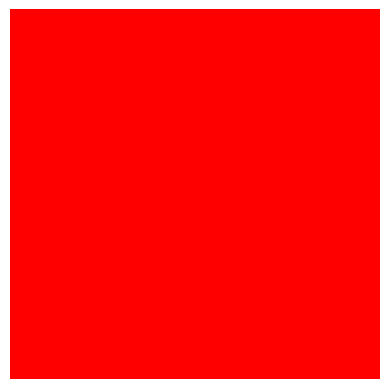

In [4]:
# Create an image buffer to store the output of your program.
OUTPUT_IMG_SIZE = (512, 512)
# output_image is a buffer of OUTPUT_IMG_SIZE[0] x OUTPUT_IMG_SIZE[1] pixels in RGBA format. It is stored in GPU memory.
# Your program is going write to this image buffer.
output_image = device.create_texture(
    type=spy.TextureType.texture_2d,
    format=spy.Format.rgba32_float,
    usage=spy.TextureUsage.unordered_access,
    width=OUTPUT_IMG_SIZE[0],
    height=OUTPUT_IMG_SIZE[1],
)
# `fillRed` is a function defined inside the `assignment1.slang` module
# This function is called compute shader. It runs on the GPU and will be executed OUTPUT_IMG_SIZE[0] x OUTPUT_IMG_SIZE[1] times.
# You can think of this as many threads running the function in parallel and every thread gets a unique value of tid.
# tid is a uint2 vector that represents the 2D coordinate of the pixel this thread is responsible for writing to.
# Read function `fillRed` in `notebooks/assignment1-part1/shaders/assignment1.slang`
assignment1_module.fillRed(
    tid=spy.grid(shape=OUTPUT_IMG_SIZE),
    _result=output_image
)
# Now, we use matplotlib to display the rendered image in output_image buffer.
plt.imshow(np.flipud(output_image.to_numpy()))
plt.axis('off')
plt.show()

### How does Each Thread Know Which Pixel to Write To?

As we mentioned earlier, the compute shader function runs on multiple threads. And in the previous cell, we dispatched the `fillRed` compute shader with a grid size of `(OUTPUT_IMG_SIZE[0], OUTPUT_IMG_SIZE[1])`. This means that the compute shader will be executed `OUTPUT_IMG_SIZE[0] x OUTPUT_IMG_SIZE[1]` times in parallel.

But how does each thread know which pixel it is responsible for writing to?

In the `fillRed` function, we have an argument `tid` of type `uint2`. This argument represents the 2D coordinate of the pixel that the current thread is responsible for writing to. When we call the `fillRed` function, we pass in `spy.grid(shape=OUTPUT_IMG_SIZE)` as the value for `tid`.

`spy.grid` is a special function provided by SlangPy that generates the grid coordinates for each thread in the dispatch grid. When a compute shader is executed, this argument will be interpreted as the current thread's coordinates in the dispatch grid.

For example, if we dispatch a compute shader with a grid ``spy.grid(shape=(4, 4))``, the tid will take values from (0, 0) to (3, 3) for each thread. You can learn more about the usage of SlangPy grid in [this documentation](https://slangpy.shader-slang.org/en/latest/src/generators/generator_grid.html).

A very common debugging trick many graphics programmers use is to render a gradient image to test if their shaders are working correctly. Here is an example of a gradient image:

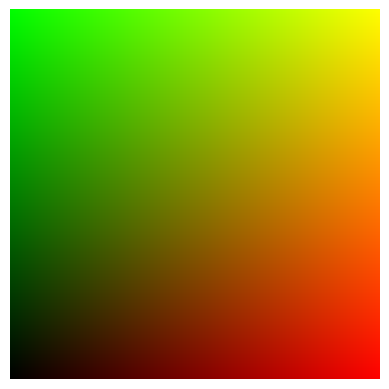

Imagine the image above is defined on a 2D coordinate system where the bottom-left corner is (0, 0) and the top-right corner is (1, 1). For reasons we'll discuss later in class, we'll refer the x direction as the u coordinate and the y direction as the v coordinate.

The red and green channels represent the u and v coordinates from (0, 0) to (1, 1) respectively. As you can see in the rendered image above, the bottom-left corner is black (0, 0), the top-left corner is green (0, 1), the bottom-right corner is red (1, 0), and the top-right corner is yellow (1, 1). So we're using this image to visualize the x and y coordinate of the pixels.

Let's try to render this uv gradient image using a compute shader in the next cell!


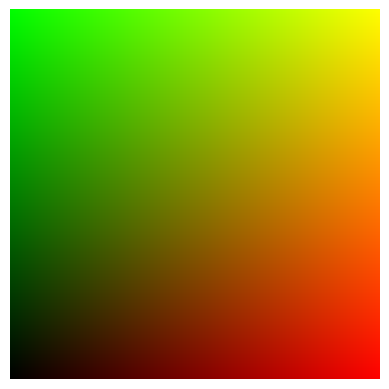

In [5]:
# You need to implement the `fillGradient` function in `notebooks/assignment1-part1/shaders/assignment1.slang` to render a uv gradient image.
# Each thread should take its 2D coordinate `tid`, normalize it to the range of (0, 1) based on the canvas size, and write the normalized value to the output image.
# For example, if the canvas size is (512, 512) and the thread's coordinate is (256, 128), the normalized coordinate should be (0.5, 0.25).
assignment1_module.fillGradient(
    tid=spy.grid(shape=OUTPUT_IMG_SIZE),
    canvasSize=np.array(OUTPUT_IMG_SIZE, dtype=np.uint32),
    _result=output_image
)
plt.imshow(np.flipud(output_image.to_numpy()))
plt.axis('off')
plt.show()

When you can get the xy coordinate for each pixel, you can render any pattern you like!

For example, let's try to render a checkerboard pattern with alternating black and white squares. Read `fillCheckerboard` in `notebooks/assignment1-part1/shaders/assignment1.slang`. Each thread takes its 2D coordinate `tid`, the canvas size, and the number of squares along each axis as input parameters.

Use the same approach as the xy gradient shader to compute the normalized coordinate of each pixel. Then, think about how to determine whether the pixel should be black or white based on its normalized coordinate and the number of squares.

If you implement the `fillCheckerboard` function correctly, you should see the following output when you run the cell below:

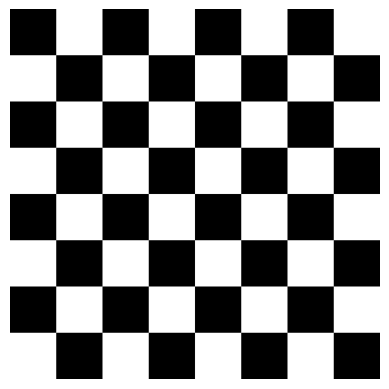

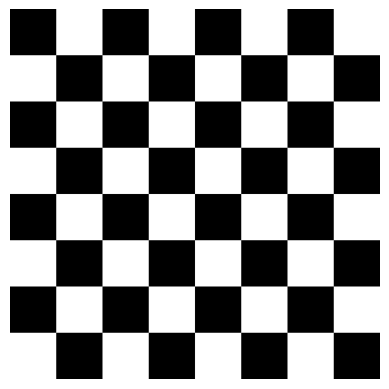

In [6]:
# Execute the compute shader to fill the texture with red color.
assignment1_module.fillCheckerboard(
    tid=spy.grid(shape=OUTPUT_IMG_SIZE),
    canvasSize=np.array(OUTPUT_IMG_SIZE, dtype=np.uint32),
    numSquares=8,
    _result=output_image
)
plt.imshow(np.flipud(output_image.to_numpy()))
plt.axis('off')
plt.show()

### (Extra Credit): 2D Triangle Rasterization

During the lecture, Kayvon mentioned how triangle rasterization works. For each pixel, you need to determine whether the pixel is inside the triangle or not. If it is inside, you can fill the pixel; otherwise, you can leave it black.

Read `triangleRasterizer` in `notebooks/assignment1-part1/shaders/assignment1.slang`. Each thread takes its 2D coordinate `tid`, the canvas size, and the triangle vertices as input parameters. The coordinates of the triangle vertices are given in normalized coordinates, which range from (0, 0) in the bottom-left corner to (1, 1) in the top-right corner. So you need to test the normalized pixel coordinate against the triangle vertices to determine whether the pixel is inside the triangle.

If you implement the `triangleRasterizer` function correctly, you should see the following output when you run the cell below:

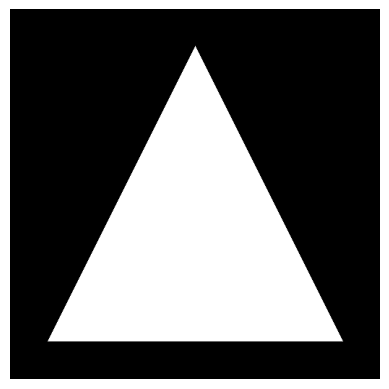

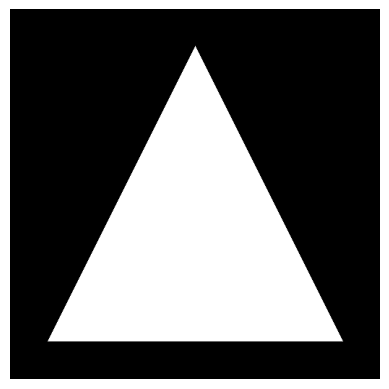

In [7]:
assignment1_module.triangleRasterizer(
    tid=spy.grid(shape=OUTPUT_IMG_SIZE),
    canvasSize=np.array(OUTPUT_IMG_SIZE, dtype=np.uint32),
    v0=np.array([0.1, 0.1], dtype=np.float32),
    v1=np.array([0.9, 0.1], dtype=np.float32),
    v2=np.array([0.5, 0.9], dtype=np.float32),
    _result=output_image
)
plt.imshow(np.flipud(output_image.to_numpy()))
plt.axis('off')
plt.show()

## 3D Ray Triangle Intersection

Now, we'll move on to the main part of this assignment: ray-triangle intersection. This is the core algorithm used in ray tracing renderers.

In this section of the assignment, you'll implement the ray-triangle intersection test algorithm we discussed in the lecture and test it using some provided rays.

### Creating and Initializing Input Buffer to Store Triangle Data

In previous section, we've created an image buffer to store the output of you shader. Now, we need to create input buffers to store the triangle data.

In [8]:
# In SlangPy, we create GPU data buffers using NDBuffer.
# When creating an NDBuffer, we need to tell SlangPy which GPU device we want to use.
# We also need to specify the data type and shape of the buffer.
# In this example, we will create a buffer that stores an array of Triangle structures.
# Read `src/cs248a_renderer/slang_shaders/model/triangle.slang` for the definition of the triangle.
triangle_buf = spy.NDBuffer(
    device=device,
    dtype=renderer_modules.primitive_module.Triangle.as_struct(),
    shape=(1,),
)
triangle_buf

NDBuffer(shape=[1], dtype=Triangle)

The `triangle_buf` we created is a GPU memory buffer that can be accessed by slang shader programs. Before we can use it in our shaders, we want to write some triangle data into the buffer from Python.

To read/write Slang buffers from Python, we need something called a shader cursor. A shader cursor is a pointer-like object that allows us to read and write data to/from Slang buffers.

In [9]:
# To read/write data in the triangle buffer, we need to create a shader cursor.
triangle_cursor = triangle_buf.cursor()

# Once we have the shader cursor, we can index into the buffer similar to how we index into a numpy array.
# Since the buffer only contains one triangle, we can index it with 0 to get the first triangle.
# Each triangle has three vertices, each vertex has a position (vec3), a normal (vec3), and a uv coordinate (vec2), and a color (vec3).
# We'll learn more about the normals, uvs, and colors later. For now, let's just focus on the positions ("vertices" field) of the triangle vertices.
triangle_cursor[0].read()

{'vertices': [{7.17e-43, 7.17e-43, 1.8e-44}, {0, 0, 0}, {0, 0, 0}],
 'normals': [{0, 0, 0}, {0, 0, 0}, {0, 0, 0}],
 'uvs': [{0, 0}, {0, 0}, {0, 0}],
 'colors': [{0, 0, 0}, {0, 0, 0}, {0, 0, 0}],
 'materialId': 0}

As you can see, the triangle buffer is not initialized with any data yet. Let's write some triangle data into the buffer.

In [10]:
# Let's create a triangle with vertices at (0.1, 0.1, -1.0), (0.9, 0.1, -1.0), and (0.5, 0.9, -1.0).
# This triangle is parallel to the xy-plane and is located at z = -1.0.
vertices = [
    np.array([0.1, 0.1, -1.0], dtype=np.float32),
    np.array([0.9, 0.1, -1.0], dtype=np.float32),
    np.array([0.5, 0.9, -1.0], dtype=np.float32),
]

# vertices = [
#     np.array([0.3, 0.4, -1.0], dtype=np.float32),
#     np.array([0.2, 0.2, -1.0], dtype=np.float32),
#     np.array([0.5, 0.4, -1.0], dtype=np.float32),
# ]
# We can also set the color of each vertex. Here, we set all vertices to red color.
colors = [
    np.array([1.0, 0.0, 0.0], dtype=np.float32) for _ in range(3)
]
triangle_cursor[0].write({
    "vertices": vertices,
    "colors": colors,
})

# IMPORTANT: After writing to the cursor, we need to call apply() to commit the changes to the GPU buffer.
# You can think of shader cursor as a pointer with a local cache.
# When we read from the buffer, the data is copied from GPU memory to the local cache.
# When we write to the cursor, the data is only written to the local cache before calling apply().
# This avoids unnecessary CPU-GPU memory transfers. The data will only be sent to GPU memory when we call apply().
triangle_cursor.apply()

# Let's read the triangle buffer again to see the updated data
triangle_buf.cursor()[0].read()

{'vertices': [{0.1, 0.1, -1}, {0.9, 0.1, -1}, {0.5, 0.9, -1}],
 'normals': [{0, 0, 0}, {0, 0, 0}, {0, 0, 0}],
 'uvs': [{0, 0}, {0, 0}, {0, 0}],
 'colors': [{1, 0, 0}, {1, 0, 0}, {1, 0, 0}],
 'materialId': 0}

Now, we have created a triangle with three vertices and written it into the triangle buffer. Let's implement the ray-triangle intersection test and render the triangle.

The code in the cell below calls the `rayTriangleTest` function in `notebooks/assignment1-part1/shaders/assignment1.slang`. Remember, this function is called for every output pixel. Each thread will generate a unique ray and intersect the ray with the Triangle provided in the input buffer. If the ray hit the triangle, the function will return the color of the triangle. If not, it'll return black.

Read `rayTriangleTest` in `notebooks/assignment1-part1/shaders/assignment1.slang` to see how we generate rays for each pixel.

Your task is to implement the ray-triangle intersection function `hit` in `src/cs248a_renderer/slang_shaders/primitive/triangle.slang`. The `hit` function takes a `Ray` and returns an `Optional<RayHitResult>`. If the ray hits the triangle, the returned `Optional` will contain a `RayHitResult` with the intersection information (distance t, normal, etc.). If the ray misses the triangle, the returned `Optional` will be empty (`Optional<RayHitResult>()`).

If your implementation is correct, running the cell below should give you this rendered image:

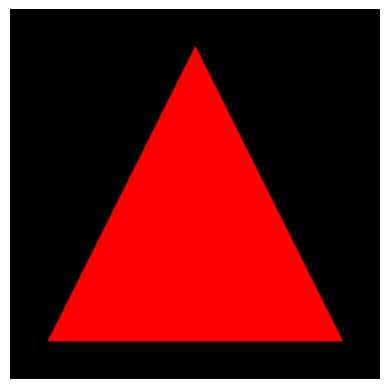

To test your implementation, change the position of the vertices in the buffer we created above to create new cases for testing. Think about what'll happen when rendering a degenerate triangle with all three vertices at the same point.

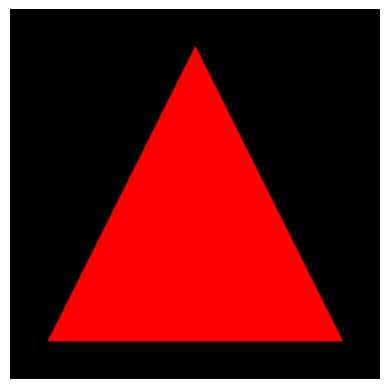

In [11]:
assignment1_module.rayTriangleTest(
    tid=spy.grid(shape=OUTPUT_IMG_SIZE),
    canvasSize=np.array(OUTPUT_IMG_SIZE, dtype=np.uint32),
    triangles=triangle_buf,
    _result=output_image
)
plt.imshow(np.flipud(output_image.to_numpy()))
plt.axis('off')
plt.show()

### Ray Triangle Intersection over the Whole Triangle Buffer

Now let's extend the single triangle intersection test to the whole triangle buffer. Implement `rayTrianglesTest` in `notebooks/assignment1/shaders/assignment1.slang` to render all triangles in the triangle buffer.

For the two triangles we defined below, you should see the following output if your intersection test is correct:

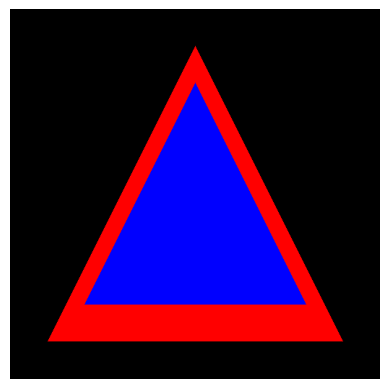

Again, make sure to test your implementation with different triangles to ensure it covers all edge cases.

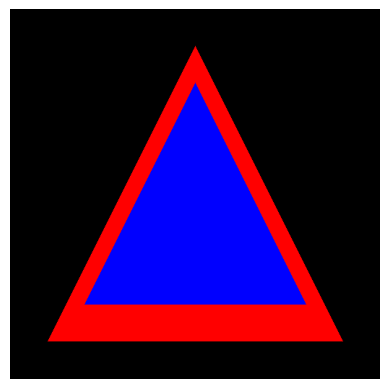

In [12]:
triangle_buf = spy.NDBuffer(
    device=device,
    dtype=renderer_modules.primitive_module.Triangle.as_struct(),
    shape=(2,),
)
triangle_cursor = triangle_buf.cursor()
# First triangle
v1 = [
    np.array([0.1, 0.1, -1.0], dtype=np.float32),
    np.array([0.9, 0.1, -1.0], dtype=np.float32),
    np.array([0.5, 0.9, -1.0], dtype=np.float32),
]
c1 = [
    np.array([1.0, 0.0, 0.0], dtype=np.float32) for _ in range(3)
]
triangle_cursor[0].write({
    "vertices": v1,
    "colors": c1,
})
# Second triangle
v2 = [
    np.array([0.2, 0.2, -0.5], dtype=np.float32),
    np.array([0.8, 0.2, -0.5], dtype=np.float32),
    np.array([0.5, 0.8, -0.5], dtype=np.float32),
]
c2 = [
    np.array([0.0, 0.0, 1.0], dtype=np.float32) for _ in range(3)
]
triangle_cursor[1].write({
    "vertices": v2,
    "colors": c2,
})

triangle_cursor.apply()

assignment1_module.rayTrianglesTest(
    tid=spy.grid(shape=OUTPUT_IMG_SIZE),
    canvasSize=np.array(OUTPUT_IMG_SIZE, dtype=np.uint32),
    triangles=triangle_buf,
    triangleCount=2,
    _result=output_image
)
plt.imshow(np.flipud(output_image.to_numpy()))
plt.axis('off')
plt.show()

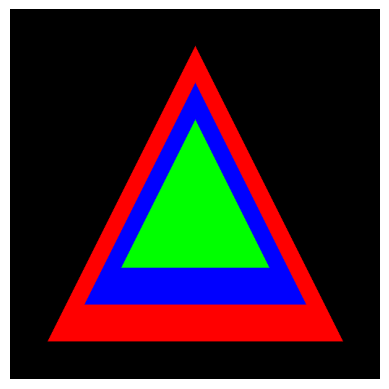

In [13]:
triangle_buf = spy.NDBuffer(
    device=device,
    dtype=renderer_modules.primitive_module.Triangle.as_struct(),
    shape=(3,),
)
triangle_cursor = triangle_buf.cursor()
# First triangle
v1 = [
    np.array([0.1, 0.1, -1.0], dtype=np.float32),
    np.array([0.9, 0.1, -1.0], dtype=np.float32),
    np.array([0.5, 0.9, -1.0], dtype=np.float32),
]
c1 = [
    np.array([1.0, 0.0, 0.0], dtype=np.float32) for _ in range(3)
]

# Second triangle
v2 = [
    np.array([0.2, 0.2, -0.5], dtype=np.float32),
    np.array([0.8, 0.2, -0.5], dtype=np.float32),
    np.array([0.5, 0.8, -0.5], dtype=np.float32),
]
c2 = [
    np.array([0.0, 0.0, 1.0], dtype=np.float32) for _ in range(3)
]

# Second triangle
v3 = [
    np.array([0.3, 0.3, -0.3], dtype=np.float32),
    np.array([0.7, 0.3, -0.3], dtype=np.float32),
    np.array([0.5, 0.7, -0.3], dtype=np.float32),
]
c3 = [
    np.array([0.0, 1.0, 0.0], dtype=np.float32) for _ in range(3)
]


triangle_cursor[0].write({
    "vertices": v1,
    "colors": c1,
})
triangle_cursor[1].write({
    "vertices": v2,
    "colors": c2,
})
triangle_cursor[2].write({
    "vertices": v3,
    "colors": c3,
})
triangle_cursor.apply()

assignment1_module.rayTrianglesTest(
    tid=spy.grid(shape=OUTPUT_IMG_SIZE),
    canvasSize=np.array(OUTPUT_IMG_SIZE, dtype=np.uint32),
    triangles=triangle_buf,
    triangleCount=3,
    _result=output_image
)
plt.imshow(np.flipud(output_image.to_numpy()))
plt.axis('off')
plt.show()

## Genrating Camera Rays and Rendering

Until now, we've testing our ray-triangle intersection algorithm within the `assignment1.slang` playground shader with manually generated rays. In the following sections, we'll implement proper camera ray generation and render a larger triangle mesh.

### Download Stanford Bunny Model

Download the `bunny.obj` and `bunny_offset_pivot.obj` files from the assignment 1 resources folder: https://drive.google.com/drive/folders/1IHUzNzK4TwybdGrdUOpoYpKfIZEC9VVY?usp=share_link

Place the files in the `resources` folder under the root directory of the repository (e.g., if your repository is located at `/path/to/cs248a-assignment`, place the files in `/path/to/cs248a-assignment/resources`). **Note:** This directory is ignored by `.gitignore`, so if you are working with your partner in group, make sure both of you have the files in your local `resources` folder.

In [14]:
OUTPUT_IMG_SIZE = (128, 128)
output_image = device.create_texture(
    type=spy.TextureType.texture_2d,
    format=spy.Format.rgba32_float,
    usage=spy.TextureUsage.unordered_access,
    width=OUTPUT_IMG_SIZE[0],
    height=OUTPUT_IMG_SIZE[1],
)

In [15]:
import open3d as o3d

# We'll load the Stanford bunny model into our scene.
scene = Scene()
o3d_mesh = o3d.io.read_triangle_mesh("../../resources/bunny_offset_pivot.obj")
mesh = Mesh(o3d_mesh)
scene.add_object(mesh)
cam = scene.camera
cam.transform.position = glm.vec3(0.0)
cam.transform.rotation = glm.quat(1.0, 0.0, 0.0, 0.0)
scene

SceneObject(name=root, transform=Transform3D(position=vec3( 0, 0, 0 ), rotation=quat( 1, 0, 0, 0 ), scale=vec3( 1, 1, 1 )), children=[
  SceneObject(name=object_1, transform=Transform3D(position=vec3( 0, 0, 0 ), rotation=quat( 1, 0, 0, 0 ), scale=vec3( 1, 1, 1 )), children=[
  ])
])

In [16]:
cam

PerspectiveCamera(name='object_0', transform=Transform3D(position=vec3( 0, 0, 0 ), rotation=quat( 1, 0, 0, 0 ), scale=vec3( 1, 1, 1 )), parent=None, children=[], fov=45.0, near=0.1, far=100.0)

Now, let's move on to the main rendering shader in `src/cs248a_renderer/slang_shaders/renderer.slang`. The entry point of the compute shader is `render`. This function will be executed for each pixel in the output image. Of course, this means that the function is responsible for calculating the final color of each pixel.

As you may recall in lecture 2, we may take multiple samples per pixel to reduce aliasing artifacts. We'll implement supersampling later in this notebook. For now, the render function will only take one sample per pixel.

The `render` function take samples by calling the `sample` function with a sceen uv coordinate. `sample` is responsible for generating a camera ray based on the screen uv coordinates and calculating the color by intersecting the ray with the triangle buffer.

We've provided the starter code for camera ray generation and final color calculation. Camera rays are generated using the `generateRay` function defined in the `Camera` struct. Your task is to implement this function in `src/cs248a_renderer/slang_shaders/model/camera.slang`.

Right now, generate all the camera rays assuming the camera is located at the origin (0, 0, 0) and looking down the **negative** z-axis.

> Why negative z-axis? In this course assignment, we use a right-handed coordinate system where the positive x-axis points to the right, the positive y-axis points up, and the positive z-axis points out of the screen towards the viewer. Therefore, when we say the camera is looking down the negative z-axis, it means the camera is looking into the scene. However, this is just a convention, and different software may use different coordinate systems. The important thing is to be consistent throughout your implementation.

![graphics-programming-be-like](https://bevy-cheatbook.github.io/img/handedness.png)

Next, you need to complete the ray-triangle intersection test in the `sample` function similar to what you've done in the `rayTrianglesTest` shader from `assignment1.slang`.

Once you find the closest intersection, pass the camera ray you generated and the `RayHitResult` you get from the intersection test to the `shade` function to compute the final color of the pixel. We've provided a simple implementation of the `shade` function to calculate the color for you. We'll learn more about lighting, shading, and materials in later assignments.

If your implementation is correct, you should see the following rendered image when you run the cell below:

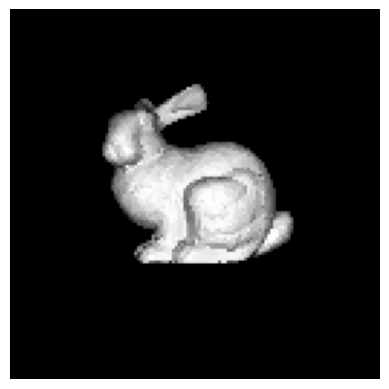

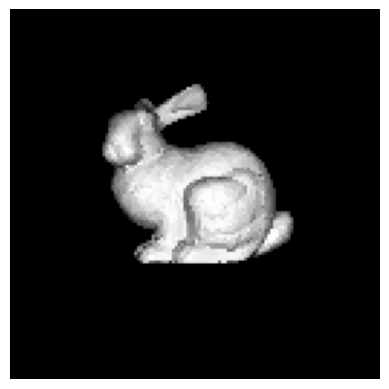

In [17]:
triangles = scene.extract_triangles()
triangle_buf = create_triangle_buf(renderer_modules.primitive_module, triangles)
renderer_modules.renderer_module.render(
    tid=spy.grid(shape=OUTPUT_IMG_SIZE),
    uniforms={
        "camera": {
            "invViewMatrix" : np.ascontiguousarray(
                glm.inverse(cam.view_matrix()), dtype=np.float32
            ),
            "canvasSize": list(OUTPUT_IMG_SIZE),
            "focalLength": float(cam.focal_length(OUTPUT_IMG_SIZE[1]))
        },
        "ambientColor": [0.0, 0.0, 0.0, 1.0],
        "sqrtSpp": 1,
        "triangleBuf": triangle_buf,
        "triangleCount": len(triangles)
    },
    _result=output_image
)
plt.imshow(np.flipud(output_image.to_numpy()))
plt.axis('off')
plt.show()

## Supersampling to Reduce Aliasing

You may noticed in the previous rendered image that there are some jagged edges along the silhouette of the bunny. This is the aliasing artifacted we discussed in lecture 2. Let's implement supersampling in our renderer to reduce these artifacts.

In the `render` function in `src/cs248a_renderer/slang_shaders/renderer.slang`, we are currently only taking one sample per pixel. To implement supersampling, you should sample `sqrtSpp x sqrtSpp` rays per pixel, where `sqrtSpp` is the square root of samples per pixel. For example, if `sqrtSpp = 4`, we will sample 16 rays per pixel in a 4x4 grid pattern.

If you implemented supersampling correctly, you should see a much smoother silhouette along the edges of the bunny (the one on the right):

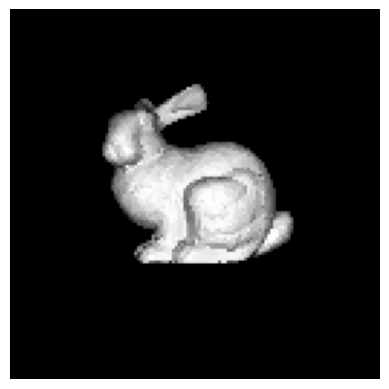
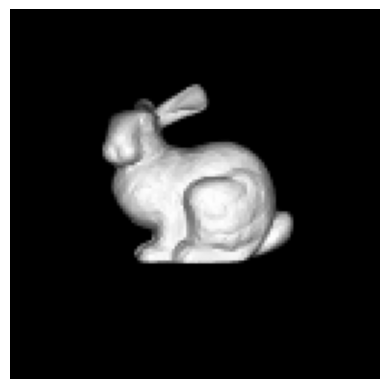

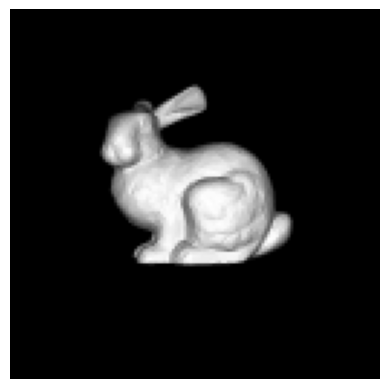

In [18]:
triangles = scene.extract_triangles()
triangle_buf = create_triangle_buf(renderer_modules.primitive_module, triangles)
renderer_modules.renderer_module.render(
    tid=spy.grid(shape=OUTPUT_IMG_SIZE),
    uniforms={
        "camera": {
            "invViewMatrix" : np.ascontiguousarray(
                glm.inverse(cam.view_matrix()), dtype=np.float32
            ),
            "canvasSize": list(OUTPUT_IMG_SIZE),
            "focalLength": float(cam.focal_length(OUTPUT_IMG_SIZE[1]))
        },
        "ambientColor": [0.0, 0.0, 0.0, 1.0],
        "sqrtSpp": 4,
        "triangleBuf": triangle_buf,
        "triangleCount": len(triangles)
    },
    _result=output_image
)
plt.imshow(np.flipud(output_image.to_numpy()))
plt.axis('off')
plt.show()

## Transformations

Finally, we've got some nice looking renderings of the bunny! But it's boring to always look at the bunny from the same angle. Let's try to introduce transformations to our renderer to allow arbitrary camera poses and object transformations.

### Implement Transform Hierarchy

Each object in our scene is a `SceneObject` defined in `src/cs248a_renderer/model/scene_object.py`. Each `SceneObject` has a `Transform3D` that defines its position, rotation, and scale in the world. Additionally, each `SceneObject` can have a parent `SceneObject`, allowing us to create a hierarchy of objects. When an object has a parent, its transform defines its position, rotation, and scale relative to its parent.

In `Transform3D` defined in `src/cs248a_renderer/model/transforms.py`, there is a method `get_matrix` that computes the 4x4 matrix that performs the position, rotation, and scale transformation defined in the `Transform3D`.

Your task is to implement the `get_transform_matrix` method in `SceneObject`. This method should compute the world transform matrix of the `SceneObject` by chaining the local transform matrices of its parent objects up to the root.

If your implementation is correct, you should get the following transform matrix for the first bunny (object_1) after running the cell below: 

```
mat4x4(( 0.707107, 0, -0.707107, 0 ), ( 0, 1, 0, 0 ), ( 0.707107, 0, 0.707107, 0 ), ( 0, 0, 0, 1 ))
```

In [19]:
# Let's load another bunny mesh and place it next to the first one.
o3d_mesh = o3d.io.read_triangle_mesh("../../resources/bunny.obj")
mesh2 = Mesh(o3d_mesh)
# We place the second bunny at the origin and rotate it 45 degrees around the y-axis.
mesh2.transform.position = glm.vec3(0.0, 0.0, 0.0)
mesh2.transform.rotation = glm.angleAxis(glm.radians(45.0), glm.vec3(0.0, 1.0, 0.0))
scene.add_object(mesh2)
# We'll parent the first bunny to the second bunny. So when the second bunny moves, the first bunny will move along with it.
scene.reparent("object_1", "object_2")
scene.lookup["object_1"].get_transform_matrix()

mat4x4(( 0.707107, 0, -0.707107, 0 ), ( 0, 1, 0, 0 ), ( 0.707107, 0, 0.707107, 0 ), ( 0, 0, 0, 1 ))

In [20]:
# Now, we'll change the camera position to (5, 5, 5) and look at the origin.
cam = scene.camera
cam.transform.position = glm.vec3(5.0, 5.0, 5.0)
cam.transform.rotation = glm.quatLookAt(glm.normalize(-cam.transform.position), glm.vec3(0.0, 1.0, 0.0))
cam

PerspectiveCamera(name='object_0', transform=Transform3D(position=vec3( 5, 5, 5 ), rotation=quat( 0.880476, -0.279848, 0.364705, 0.115917 ), scale=vec3( 1, 1, 1 )), parent=None, children=[], fov=45.0, near=0.1, far=100.0)

Now, you've implemented the transform hierarchy for the scene objects that transform from local space (some times called object space or model sapce) to world space.

Next, we'll implement camera ray transformation to support arbitrary camera poses.

As you may recall in the previous section, camera rays are generated assuming the camera is located at the origin (0, 0, 0) and looking down the negative z-axis. This is the local space of the camera (also called camera space or view space). To support arbitrary camera poses, we need to transform the camera rays from camera space to world space so that these rays can be intersected with the triangles of the scene objects in world space.

In `src/cs248a_renderer/model/cameras.py`, we defined the `PerspectiveCamera` with a transform. We pass in the matrix of the camera transform to the `invViewMatrix` through the uniforms in the following cell.

> Why invViewMatrix? In computer graphics, the view matrix is defined as the matrix that transform from world space to camera space. Here, we want to transform camera rays from camera space to world space. Therefore, we need to use the inverse of the view matrix, which is the matrix that transforms from camera space to world space.

Now, implement `transform` function in the `Ray` struct defined in `src/cs248a_renderer/slang_shaders/math/ray.slang`. This function should return a new `Ray` that is transformed by the given 4x4 matrix. Remember a ray is defined by an origin point and a direction vector. How do you transform a point and a vector using a 4x4 matrix?

After you implement the ray transform function, modify the `generateRay` function in the `Camera` struct to transform the generated camera ray from camera space to world space using the `invViewMatrix` of the camera.

If your implementation is correct, you should see the rotated bunny rendered from the new camera angle after running the cell below:

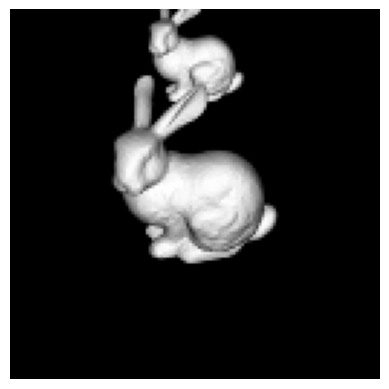

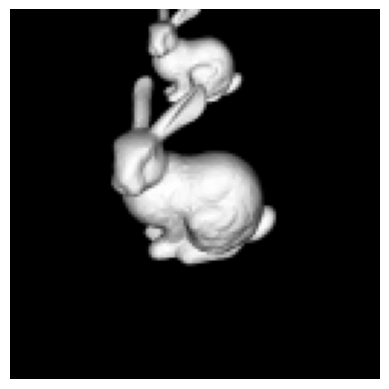

In [21]:
triangles = scene.extract_triangles()
triangle_buf = create_triangle_buf(renderer_modules.primitive_module, triangles)
renderer_modules.renderer_module.render(
    tid=spy.grid(shape=OUTPUT_IMG_SIZE),
    uniforms={
        "camera": {
            "invViewMatrix" : np.ascontiguousarray(
                cam.transform.get_matrix(), dtype=np.float32
            ),
            "canvasSize": list(OUTPUT_IMG_SIZE),
            "focalLength": float(cam.focal_length(OUTPUT_IMG_SIZE[1]))
        },
        "ambientColor": [0.0, 0.0, 0.0, 1.0],
        "sqrtSpp": 4,
        "triangleBuf": triangle_buf,
        "triangleCount": len(triangles)
    },
    _result=output_image
)
plt.imshow(np.flipud(output_image.to_numpy()))
plt.axis('off')
plt.show()